In [1]:
__author__ = 'Benjamin Alan Weaver <baweaver@lbl.gov>'
__version__ '20181221'
__datasets__ = ['sdss_dr13', 'sdss_dr14']
__keywords__ = ['extragalactic', 'spectroscopic redshift']

SyntaxError: invalid syntax (<ipython-input-1-f55661a418ea>, line 2)

# Exploring SDSS Data in NOAO Data Lab

*Benjamin Alan Weaver & NOAO Data Lab Team*

### Table of Contents

* [Goals & Notebook Summary](#Goals)
* [Disclaimer & Attribution](#Disclaimer-&-Attribution)
* [Imports & Setup](#Imports-&-Setup)
* [BOSS Galaxies (photometry)](#BOSS-Galaxies-in-the-SDSS-Photometric-Catalog)
* [BOSS Galaxies (spectroscopy)](#BOSS-Galaxies-in-the-SDSS-Spectroscopic-Catalog)
* [Plotting SDSS Spectra](#Plotting-SDSS-Spectra)
* [Display SDSS Images](#Display-SDSS-Images)
* [Resources & References](#Resources-&-References)

## Goals

Work with SDSS tables in the Data Lab database.

## Notebook Summary

We're bringing the SDSS-III/IV (DR8-DR14) data archive to NOAO, and some of the data are already available in Data Lab.  This notebook demonstrates some queries and plots of SDSS data.

The SDSS website is [www.sdss.org](https://www.sdss.org).

The examples below are primarily focused on target selection and spectroscopy for the [BOSS survey](https://www.sdss.org/surveys/boss/).  This notebook makes extensive use of the target selection algorithms described by [Reid et al. (2016)](http://adsabs.harvard.edu/abs/2016MNRAS.455.1553R).

## Disclaimer & Attribution

If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick *et al.*, "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445
* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

## Imports & Setup

In [2]:
# Standard library
from contextlib import contextmanager
from getpass import getpass
from io import BytesIO
from bz2 import BZ2File
from time import sleep
# matplotlib, etc.
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from matplotlib.font_manager import fontManager, FontProperties
import numpy as np
from astropy.io.votable import parse_single_table
# Data Lab
from dl import queryClient as qc, storeClient as sc


def sdss_objid(data):
    """Convert SDSS photometric identifiers into CAS-style ObjID.

    Bits are assigned in objid thus:

    ===== ========== ===============================================
    Bits  Name       Comment
    ===== ========== ===============================================
    63    empty      unassigned
    59-62 skyVersion resolved sky version (0-15)
    48-58 rerun      number of pipeline rerun
    32-47 run        run number
    29-31 camcol     camera column (1-6)
    28    firstField [is this the first field in segment?] 0 for now
    16-27 field      field number within run
    0-15  object     object number within field
    ===== ========== ===============================================

    Parameters
    ----------
    data : :class:`numpy.ndarray`
        Array containing 'rerun', 'run', 'camcol', 'field', 'id'.
    
    Returns
    -------
    :class:`numpy.ndarray` of :class:`numpy.uint64`
        The ObjIDs of the objects.
    
    Raises
    ------
    ValueError
        If the sizes of the arrays don't match or if the array values are
        out of bounds.
    
    Notes
    -----
    * ``firstField`` flag never set.
    * On 32-bit systems, makes sure to explicitly declare all inputs as
      64-bit integers.
    """
    skyversion = np.zeros(data.shape, dtype=np.uint64) + 2
    rerun = np.array(list(map(int, data['rerun'].tolist())), dtype=np.uint64)
    run = data['run'].astype(np.uint64)
    camcol = data['camcol'].astype(np.uint64)
    firstfield = np.zeros(data.shape, dtype=np.uint64)
    field = data['field'].astype(np.uint64)
    objnum = data['id'].astype(np.uint64)
    #
    # Check ranges of parameters
    #
    if ((skyversion < 0) | (skyversion >= 16)).any():
        raise ValueError("skyversion values are out-of-bounds!")
    if ((rerun < 0) | (rerun >= 2**11)).any():
        raise ValueError("rerun values are out-of-bounds!")
    if ((run < 0) | (run >= 2**16)).any():
        raise ValueError("run values are out-of-bounds!")
    if ((camcol < 1) | (camcol > 6)).any():
        raise ValueError("camcol values are out-of-bounds!")
    if ((field < 0) | (field >= 2**12)).any():
        raise ValueError("field values are out-of-bounds!")
    if ((objnum < 0) | (objnum >= 2**16)).any():
        raise ValueError("id values are out-of-bounds!")
    #
    # Compute the objid
    #
    objid = ((skyversion << 59) |
             (rerun << 48) |
             (run << 32) |
             (camcol << 29) |
             (firstfield << 28) |
             (field << 16) |
             (objnum))
    return objid


def asinh_mag(data, magtype='model', bands='ugriz', deredden=False):
    """Convert fluxes to asinh magnitudes.

    Parameters
    ----------
    data : :class:`numpy.ndarray`
        Array containing fluxes in units of nanomaggies.
    magtype : :class:`str`, optional
        Name of the type of magnitude to compute, *e.g.*, 'model' or 'psf'.
        'model' is the default.
    bands : :class:`str`, optional
        Filter bands to compute.  Default is 'ugriz'.
    deredden : :class:`bool`, optional
        If ``True``, also apply extinction correction to the magnitude.
        Extinction values must be present in `data`.

    Returns
    -------
    :class:`numpy.ndarray`
        Asinh magnitudes with columns renamed to, *e.g.*, ``modelflux_g`` to ``modelmag_g``.
    """
    dt = data['{0}flux_{1}'.format(magtype, bands[0])].dtype
    C = -2.5/np.log(10.0)
    b = np.array([(1.4e-10, 0.9e-10, 1.2e-10, 1.8e-10, 7.4e-10)], dtype=[(str(band), dt) for band in bands])
    mag = np.zeros(data.shape, dtype=[(str('{0}mag_{1}'.format(magtype, band)), dt) for band in bands])
    for i, band in enumerate(bands):
        mag['{0}mag_{1}'.format(magtype, band)] = C*(np.arcsinh((data["{0}flux_{1}".format(magtype, band)]*1.0e-9)/(2.0*b[band])) + np.log(b[band]))
        if deredden:
            mag['{0}mag_{1}'.format(magtype, band)] -= data['extinction_{0}'.format(band)]
    return mag


def auxilliary_colors(data, bands='ugriz'):
    """Compute some artificial color quantities useful for target selection.

    Parameters
    ----------
    data : :class:`numpy.ndarray`
        Array containing MODEL fluxes.
    bands : :class:`str`, optional
        Filter bands to compute.  Default is 'ugriz'.

    Returns
    -------
    :class:`numpy.ndarray`
        Array containing auxilliary colors.
    """
    dt = data['modelmag_{0}'.format(bands[0])].dtype
    aux = np.zeros(data.shape, dtype=[(str('c_par'), dt), (str('c_perp'), dt), (str('d_perp'), dt)])
    aux['c_par'] = (0.7 * (data['modelmag_g'] - data['modelmag_r']) +
                    1.2 * (data['modelmag_r'] - data['modelmag_i'] - 0.18))
    aux['c_perp'] = ((data['modelmag_r'] - data['modelmag_i']) - 
                     (data['modelmag_g'] - data['modelmag_r'])/4.0 - 0.18)
    aux['d_perp'] = ((data['modelmag_r'] - data['modelmag_i']) -
                     (data['modelmag_g'] - data['modelmag_r'])/8.0)
    return aux


def extract_spectrum(plate, mjd, fiber, run2d='v5_10_0', release=14, sas='sdss_dr14://'):
    """Extract a spectrum from a spPlate file.
    
    Parameters
    ----------
    plate : :class:`int`
        Plate of observation.
    mjd : :class:`int`
        MJD of observation.
    fiber : :class:`int`
        Fiber number.
    run2d : :class:`str`, optional
        Reduction id.
    release : :class:`int`, optional
        Data release number.
    sas : :class:`str`, optional
        Root path to SDSS data.
    
    Returns
    -------
    :func:`tuple`
        A tuple containing wavelength, flux, inverse variance of flux, and sky spectrum.
    """
    vopath = "{0}sdss/spectro/redux/{1}/{2:04d}/spPlate-{2:04d}-{3:05d}.fits".format(sas, run2d, plate, mjd)
    with fits.open(sc.get(vopath, mode='fileobj')) as hdulist:
        hdr = hdulist[0].header
        flux = hdulist[0].data[fiber-1, :]
        ivar = hdulist[1].data[fiber-1, :]
        sky = hdulist[6].data[fiber-1, :]
    loglam = hdr['COEFF0'] + hdr['COEFF1']*np.arange(hdr['NAXIS1'], dtype=flux.dtype)
    wavelength = 10.0**loglam
    return wavelength, flux, ivar, sky


def plot_spectrum(plate, mjd, fiber, showsky=False, **kwargs):
    """Simple SDSS/BOSS spectrum plot.
    
    Parameters
    ----------
    plate : :class:`int`
        Plate of observation.
    mjd : :class:`int`
        MJD of observation.
    fiber : :class:`int`
        Fiber number.
    showsky : :class:`bool`, optional
        If ``True``, plot the sky spectrum
    """
    wavelength, flux, ivar, sky = extract_spectrum(plate, mjd, fiber, **kwargs)
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)
    p0 = ax.plot(wavelength, flux, 'k-', linewidth=1, label='OBJECT')
    if showsky:
        p1 = ax.plot(wavelength, sky, 'm-', linewidth=1, label='SKY')
    foo = ax.set_title("{0:04d}-{1:05d}-{2:04d}".format(plate, mjd, fiber))
    foo = ax.set_xlabel("Wavelength [Å]")
    foo = ax.set_ylabel(r"Flux [$10^{-17} \; \mathrm{erg} \; \mathrm{cm}^{-2} \; \mathrm{s}^{-1} \; \mathrm{\AA}^{-1}$]")
    l = ax.legend()

## BOSS Galaxies in the SDSS Photometric Catalog

Currently, NOAO Data Lab has loaded a subset of the full SDSS photometric catalog that contains the most commonly used data columns from the full catalog.  This subset is actually provided by SDSS for convenience.  This subset is colloquially known as the "Sweep files".  The contents of these files is described in this [data model](https://data.sdss.org/datamodel/files/PHOTO_SWEEP/RERUN/calibObj.html).

There are several types of flux measurements reported by SDSS.  See the [SDSS Magnitudes page](http://www.sdss.org/dr13/algorithms/magnitudes/) for further details.  The "Sweep files" only contain *fluxes* not magnitudes, so we have to convert the fluxes to (asinh) magnitudes offline.

We're going to select several measurements of flux, and choose objects marked as `SURVEY_PRIMARY` in the [RESOLVE_STATUS bitmask](http://www.sdss.org/dr13/algorithms/bitmasks/#RESOLVE_STATUS) (see the [resolve](http://www.sdss.org/dr13/algorithms/resolve/) documentation for further details.

Note that bitwise operations that are normally part of the SQL standard are forbidden by [ADQL](http://www.ivoa.net/documents/latest/ADQL.html) (even though the `&` operator is part of the ADQL standard).

In [3]:
release = 13
select_magnitudes = ', '.join([', '.join(['{0}flux_{1}'.format(magtype, b)
                                          for b in 'ugriz'])
                               for magtype in ('model', 'dev', 'exp', 'psf', 'fiber2')])
select_cmodel = ', '.join(['((fracdev_{0} * devflux_{0}) + (1.0 - fracdev_{0}) * expflux_{0}) AS cmodelflux_{0}'.format(b)
                           for b in 'ugriz'])
select_other = ', '.join([', '.join(['{0}_{1}'.format(col, b) for b in 'ugriz'])
                          for col in ('fracdev', 'theta_dev', 'extinction')])
q = ("SELECT rerun, run, camcol, field, id, ra, dec, " +
     select_magnitudes + ", " +
     select_cmodel + ", " +
     select_other +
     " FROM sdss_dr{0:d}.calibobj_gal WHERE (resolve_status & 256) != 0 LIMIT 100000".format(release))
     # " FROM sdss_dr{0:d}.calibobj_gal LIMIT 10".format(release))
print(q)

SELECT rerun, run, camcol, field, id, ra, dec, modelflux_u, modelflux_g, modelflux_r, modelflux_i, modelflux_z, devflux_u, devflux_g, devflux_r, devflux_i, devflux_z, expflux_u, expflux_g, expflux_r, expflux_i, expflux_z, psfflux_u, psfflux_g, psfflux_r, psfflux_i, psfflux_z, fiber2flux_u, fiber2flux_g, fiber2flux_r, fiber2flux_i, fiber2flux_z, ((fracdev_u * devflux_u) + (1.0 - fracdev_u) * expflux_u) AS cmodelflux_u, ((fracdev_g * devflux_g) + (1.0 - fracdev_g) * expflux_g) AS cmodelflux_g, ((fracdev_r * devflux_r) + (1.0 - fracdev_r) * expflux_r) AS cmodelflux_r, ((fracdev_i * devflux_i) + (1.0 - fracdev_i) * expflux_i) AS cmodelflux_i, ((fracdev_z * devflux_z) + (1.0 - fracdev_z) * expflux_z) AS cmodelflux_z, fracdev_u, fracdev_g, fracdev_r, fracdev_i, fracdev_z, theta_dev_u, theta_dev_g, theta_dev_r, theta_dev_i, theta_dev_z, extinction_u, extinction_g, extinction_r, extinction_i, extinction_z FROM sdss_dr13.calibobj_gal WHERE (resolve_status & 256) != 0 LIMIT 100000


In [4]:
%%time
try:
    vot = qc.query(sql=q, fmt='votable', async=False)
except Exception as e:
    print(e.message)
else:
    print(vot[:50])

<?xml version="1.0" encoding="utf-8"?>
<!-- Produc
CPU times: user 432 ms, sys: 341 ms, total: 773 ms
Wall time: 2min 5s


In [5]:
result = parse_single_table(BytesIO(vot.encode('utf-8')))
objID = sdss_objid(result.array)
psfmag = asinh_mag(result.array, magtype='psf', deredden=True)
cmodelmag = asinh_mag(result.array, magtype='cmodel', deredden=True)
modelmag = asinh_mag(result.array, magtype='model', deredden=True)
fib2mag = asinh_mag(result.array, magtype='fiber2', deredden=True)
rdev_i = result.array['theta_dev_i']/0.396  # convert back to pixels
auxcolor = auxilliary_colors(modelmag)

In [6]:
LOWZ = ((cmodelmag['cmodelmag_r'] < (13.5 + auxcolor['c_par']/0.3)) & 
        (np.abs(auxcolor['c_perp']) < 0.2) &
        (cmodelmag['cmodelmag_r'] > 16.0) & (cmodelmag['cmodelmag_r'] < 19.6) &
        ((psfmag['psfmag_r'] - cmodelmag['cmodelmag_r']) > 0.3))
CMASS = ((cmodelmag['cmodelmag_i'] < (19.86 + 1.6*(auxcolor['d_perp'] - 0.8))) &
         (cmodelmag['cmodelmag_i'] > 17.5) & (cmodelmag['cmodelmag_i'] < 19.9) &
         (auxcolor['d_perp'] > 0.55) &
         ((psfmag['psfmag_i'] - modelmag['modelmag_i']) > (0.2 + 0.2*(20.0 - modelmag['modelmag_i']))) &
         ((psfmag['psfmag_z'] - modelmag['modelmag_z']) > (9.125 - 0.46*modelmag['modelmag_z'])) &
         ((modelmag['modelmag_r'] - modelmag['modelmag_i']) < 2) &
         (fib2mag['fiber2mag_i'] < 21.5) & 
         (rdev_i < 20))

In [7]:
print(LOWZ.sum())
print(CMASS.sum())

973
1485


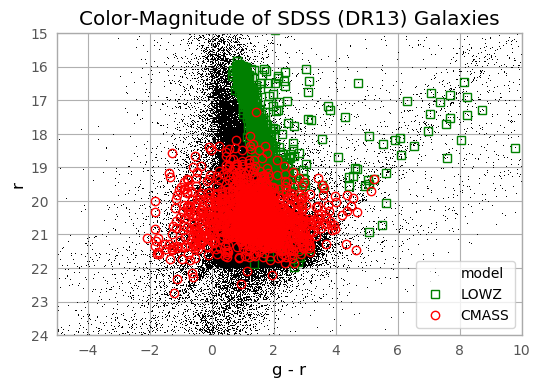

In [8]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
p1 = ax.plot(modelmag['modelmag_g'] - modelmag['modelmag_r'], modelmag['modelmag_r'], 'k,', label='model')
p2 = ax.plot(modelmag['modelmag_g'][LOWZ] - modelmag['modelmag_r'][LOWZ], modelmag['modelmag_r'][LOWZ], 'gs', label='LOWZ')
p3 = ax.plot(modelmag['modelmag_g'][CMASS] - modelmag['modelmag_r'][CMASS], modelmag['modelmag_r'][CMASS], 'ro', label='CMASS')
foo = p2[0].set_markeredgecolor('g')
foo = p2[0].set_markerfacecolor('none')
foo = p3[0].set_markeredgecolor('r')
foo = p3[0].set_markerfacecolor('none')
foo = ax.set_xlim([-5, 10])
foo = ax.set_ylim([24, 15])
foo = ax.set_xlabel('g - r')
foo = ax.set_ylabel('r')
foo = ax.set_title('Color-Magnitude of SDSS (DR13) Galaxies')
l = ax.legend(numpoints=1)

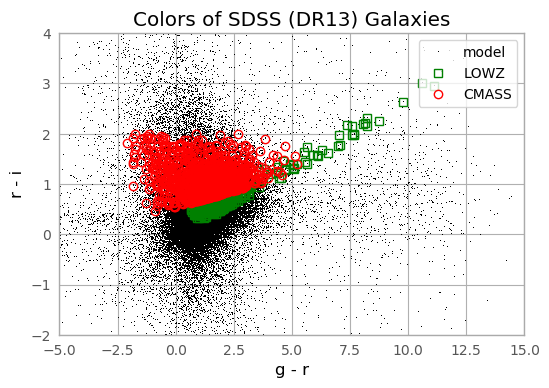

In [9]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
p1 = ax.plot(modelmag['modelmag_g'] - modelmag['modelmag_r'],
             modelmag['modelmag_r'] - modelmag['modelmag_i'], 'k,', label='model')
p2 = ax.plot(modelmag['modelmag_g'][LOWZ] - modelmag['modelmag_r'][LOWZ], 
             modelmag['modelmag_r'][LOWZ] - modelmag['modelmag_i'][LOWZ], 'gs', label='LOWZ')
p3 = ax.plot(modelmag['modelmag_g'][CMASS] - modelmag['modelmag_r'][CMASS], 
             modelmag['modelmag_r'][CMASS] - modelmag['modelmag_i'][CMASS], 'ro', label='CMASS')
foo = p2[0].set_markeredgecolor('g')
foo = p2[0].set_markerfacecolor('none')
foo = p3[0].set_markeredgecolor('r')
foo = p3[0].set_markerfacecolor('none')
foo = ax.set_xlim([-5, 15])
foo = ax.set_ylim([-2, 4])
foo = ax.set_xlabel('g - r')
foo = ax.set_ylabel('r - i')
foo = ax.set_title('Colors of SDSS (DR13) Galaxies')
l = ax.legend(numpoints=1)

## BOSS Galaxies in the SDSS Spectroscopic Catalog

### Number of Objects

How many objects are in the specObj table?

In [10]:
%%time
q = "SELECT COUNT(*) AS nrows FROM sdss_dr{0:d}.specobj".format(release)
result = qc.query(adql=q, fmt='csv')
print(result)

nrows
4411200

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 1.22 s


### Select LOWZ and CMASS spectra.

The [BOSS_TARGET1 bitmask](http://www.sdss.org/dr13/algorithms/bitmasks/#BOSS_TARGET1) makes this very easy.  SDSS [uses bitmasks extensively](http://www.sdss.org/dr13/algorithms/bitmasks/)!

In [11]:
%%time
q = ("SELECT boss_target1 FROM sdss_dr{0:d}.specobj WHERE boss_target1 != 0 LIMIT 100000".format(release))
try:
    vot = qc.query(sql=q, fmt='votable')
except Exception as e:
    print(e.message)
else:
    result = parse_single_table(BytesIO(vot.encode('utf-8')))
    boss_target1 = result.array['boss_target1']
    print(boss_target1)

[134 134 134 ... 16492675088384 134 134]
CPU times: user 761 ms, sys: 48 ms, total: 809 ms
Wall time: 3.03 s


In [12]:
for mask in (1, 5, 6, 9, 14, 15, 33, 41, 133, 134, 135, 140, 141, 142):
    print(mask, (boss_target1 == mask).sum())

1 24315
5 0
6 1169
9 459
14 2736
15 17
33 1
41 126
133 4
134 43214
135 690
140 3194
141 1
142 0


In [13]:
%%time
q_lowz = ("SELECT specobjid, fluxobjid, bestobjid, plate, mjd, fiberid, z_noqso FROM sdss_dr{0:d}.specobj " + 
          "WHERE (boss_target1 & {1:d}) != 0 AND specprimary = 1 AND " +
          "zwarning_noqso = 0 AND class_noqso = 'GALAXY' LIMIT 100000").format(release, 1)
# jobId = qc.query(sql=q, fmt='votable', async=True)
result = parse_single_table(BytesIO(qc.query(sql=q_lowz, fmt='votable').encode('utf-8')))
plate_lowz = result.array['plate']
mjd_lowz = result.array['mjd']
fiber_lowz = result.array['fiberid']
redshift_lowz = result.array['z_noqso']
print(len(redshift_lowz))

100000
CPU times: user 3.44 s, sys: 145 ms, total: 3.59 s
Wall time: 17.7 s


In [14]:
%%time
q_cmass = ("SELECT specobjid, fluxobjid, bestobjid, plate, mjd, fiberid, z_noqso FROM sdss_dr{0:d}.specobj " + 
           "WHERE (boss_target1 & {1:d}) != 0 AND specprimary = 1 AND " +
           "zwarning_noqso = 0 AND class_noqso = 'GALAXY' LIMIT 100000").format(release, 2)
result = parse_single_table(BytesIO(qc.query(sql=q_cmass, fmt='votable').encode('utf-8')))
plate_cmass = result.array['plate']
mjd_cmass = result.array['mjd']
fiber_cmass = result.array['fiberid']
redshift_cmass = result.array['z_noqso']
print(len(redshift_cmass))

100000
CPU times: user 3.47 s, sys: 121 ms, total: 3.59 s
Wall time: 16.4 s


### Redshift Distribution

Here's the redshift distribution of LOWZ and CMASS galaxies.  Note that the number of bins for CMASS is chosen so the bin *sizes* are approximately the same as the LOWZ sample (when the entire data set can be queried).

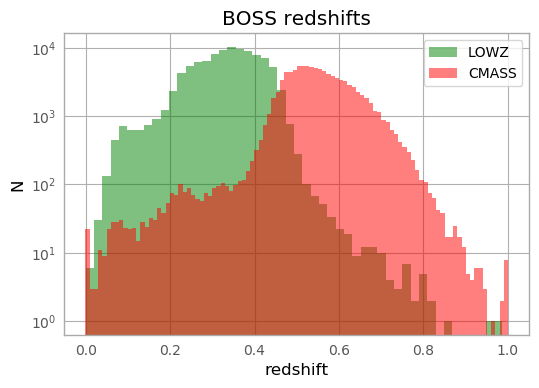

In [15]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
n_lowz, bins_lowz, patches_lowz = ax.hist(redshift_lowz, 50, facecolor='green', alpha=0.5, label='LOWZ')
n_cmass, bins_cmass, patches_cmass = ax.hist(redshift_cmass, 100, facecolor='red', alpha=0.5, label='CMASS')
foo = ax.set_yscale('log')
foo = ax.grid(True)
foo = ax.set_xlabel("redshift")
foo = ax.set_ylabel("N")
foo = ax.set_title("BOSS redshifts")
foo = ax.legend()

### What's that? Some CMASS Galaxies have negative redshift?

Let's actually take a look at these spectra.

In [16]:
rerun = 'v5_10_0'
from IPython.core.display import display, HTML
negative_z = (redshift_cmass > bins_cmass[0]) & (redshift_cmass < bins_cmass[1])
display(HTML('<ul>'))
for p, m, f in zip(plate_cmass[negative_z], mjd_cmass[negative_z], fiber_cmass[negative_z]):
    display(HTML('<li><a href="https://dr{0:d}.sdss.org/optical/spectrum/view?run2d={1}&plateid={2}&mjd={3}&fiberid={4}">{2}, {3}, {4}</a></li>'.format(release, rerun, p, m, f)))
display(HTML('</ul>'))

Hmmm, after looking at a few of these, a number of them are point-like, red objects that are close to a brighter object.  A plausible hypothesis is that CMASS color selection doesn't work so great when a nearby, brighter object might be contaminating the photometry, making it harder to distinguish LRGs from M stars.

## Plotting SDSS Spectra

In addition to databases that contain the SDSS catalog data, NOAO Data Lab will also contain the images and spectra themselves.  In fact, some spectroscopic data is already in the NOAO archive, so we can plot it directly from a Data Lab notebook!

First, some spectra from the previous list.  You can get a better view of these spectra from the links above, but this demonstrates the fun fact that many BOSS spectra are *fainter* than the sky!

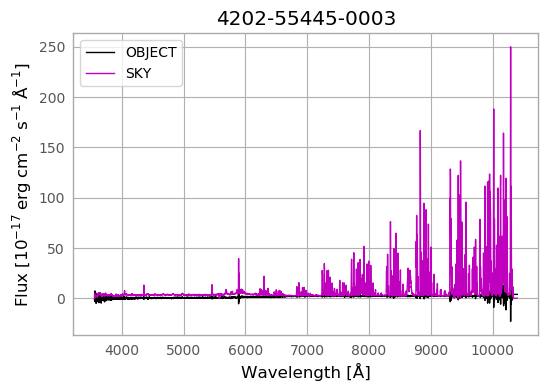

In [17]:
plot_spectrum(4202, 55445, 3, showsky=True)

Here's another from the list above.  If you look in the 6000 - 8000 Å range, you can see some features that resemble certain M stars.

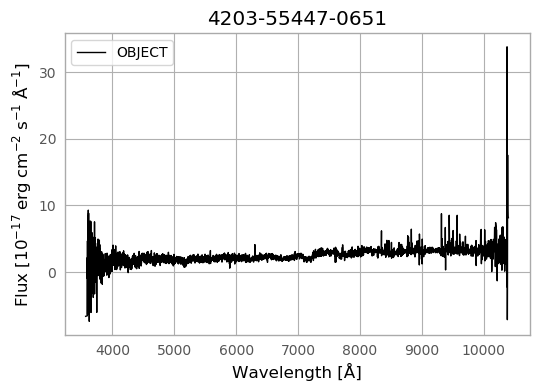

In [18]:
plot_spectrum(4203, 55447, 651)

Here's a "classic" LRG at redshift 0.67 (which was actually targeted as LOWZ!).

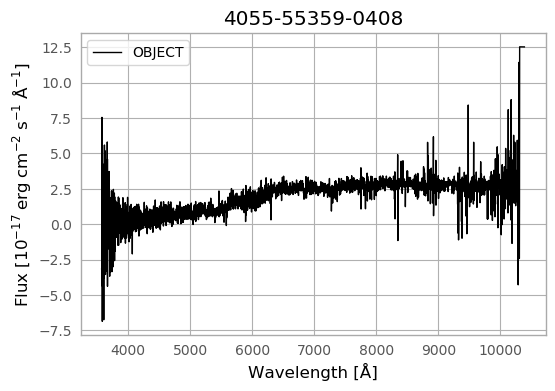

In [19]:
plot_spectrum(4055, 55359, 408)

## Display SDSS Images

Practice plotting corrected frame images in Data Lab.  The original image is [here](https://dr12.sdss.org/fields/runCamcolField?field=13&camcol=1&run=6122).

In [20]:
def asinh_image(image, band='r'):
    """Convert an image in nanomaggies into asinh magnitudes.
    
    Parameters
    ----------
    image : :class:`numpy.ndarray`
        Image data, read from *e.g.* a SDSS-III corrected frame file.
    band : :class:`str`, optional
        Filter band, default *r*.
    
    Returns
    -------
    :class:`numpy.ndarray`
        Image data converted to asinh magnitudes.
    """
    C = -2.5/np.log(10.0)
    b = dict(u=1.4e-10, g=0.9e-10, r=1.2e-10, i=1.8e-10, z=7.4e-10)
    mag = C*(np.arcsinh((image*1.0e-9)/(2.0*b[band])) + np.log(b[band]))
    return mag


def extract_frame(run, camcol, field, band, sas='sdss_dr14://'):
    """Obtain image data from a SDSS corrected frame, which may be at a remote location.

    Parameters
    ----------
    run : :class:`int`
        Run number.
    camcol : :class:`int`
        Column number.
    field : :class:`int`
        Field number
    band : :class:`str`
        Filter band.
    sas : :class:`str`, optional
        Root path to SDSS data.
    
    Returns
    -------
    :class:`numpy.ndarray`
        Image data.
    """
    fm = '{0}eboss/photoObj/frames/301/{1:d}/{2:d}/frame-{3}-{1:06d}-{2:d}-{4:04d}.fits.bz2'.format(sas, run, camcol, band, field)
    with BZ2File(BytesIO(sc.get(fm, mode='binary'))) as cf:
        with fits.open(cf) as hdulist:
            image = hdulist[0].data
    return image


def display_frame(run, camcol, field, band, invert=False, **kwargs):
    """Display a SDSS corrected frame.
    
    Parameters
    ----------
    run : :class:`int`
        Run number.
    camcol : :class:`int`
        Column number.
    field : :class:`int`
        Field number.
    band : :class:`str`
        Filter band.
    invert : :class:`bool`, optional
        If ``True`` display an inverted grayscale image.
    sas : :class:`str`, optional
        Root path to SDSS data.

    Returns
    -------
    :func:`tuple`
         Handles to the figure, image and colorbar.
    """
    color_map = 'gray_r'
    if invert:
        color_map = 'gray'
    image = extract_frame(run, camcol, field, band, **kwargs)
    mag_image = asinh_image(image, band=band)
    fig = plt.figure(dpi=100)
    im = plt.imshow(mag_image, cmap=color_map, clim=(26, 18), origin='lower')
    foo = im.axes.set_title('frame-{0}-{1:06d}-{2:d}-{3:04d}.fits'.format(band, run, camcol, field))
    foo = im.axes.grid(True)
    cb = plt.colorbar()
    return fig, im, cb

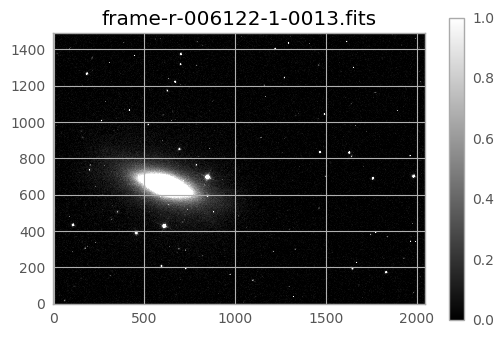

In [21]:
image = extract_frame(6122, 1, 13, 'r')
fig = plt.figure(dpi=100)
im = plt.imshow(image, cmap='gray', clim=(0.0, 1.0), origin='lower')
foo = im.axes.set_title('frame-r-006122-1-0013.fits')
foo = im.axes.grid(True)
cb = plt.colorbar()

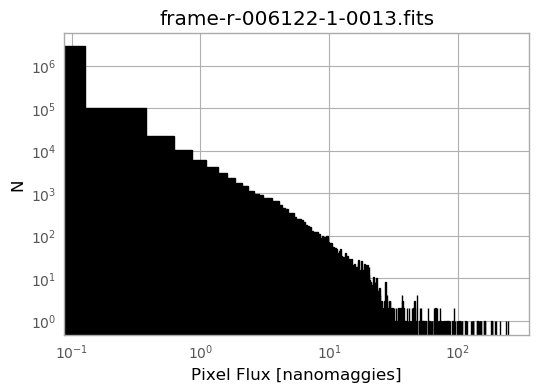

In [22]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(image.flatten(), bins=1000, facecolor='k', edgecolor='k')
foo = ax.set_xscale('log')
foo = ax.set_yscale('log')
foo = ax.grid(True)
foo = ax.set_xlabel('Pixel Flux [nanomaggies]')
foo = ax.set_ylabel('N')
foo = ax.set_title('frame-r-006122-1-0013.fits')

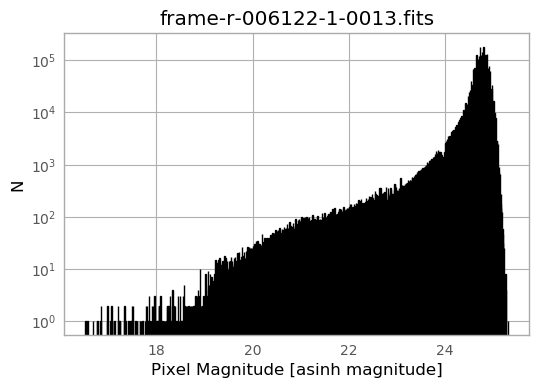

In [23]:
mag_image = asinh_image(image, band='r')
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(mag_image.flatten(), bins=1000, facecolor='k', edgecolor='k')
# foo = ax.set_xscale('log')
foo = ax.set_yscale('log')
foo = ax.grid(True)
foo = ax.set_xlabel('Pixel Magnitude [asinh magnitude]')
foo = ax.set_ylabel('N')
foo = ax.set_title('frame-r-006122-1-0013.fits')# foo = ax.set_xlabel("redshift")

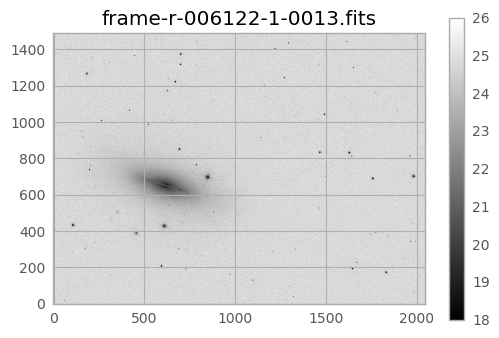

In [24]:
fig = plt.figure(dpi=100)
im = plt.imshow(mag_image, cmap='gray', clim=(26, 18), origin='lower')
foo = im.axes.set_title('frame-r-006122-1-0013.fits')
foo = im.axes.grid(True)
cb = plt.colorbar()

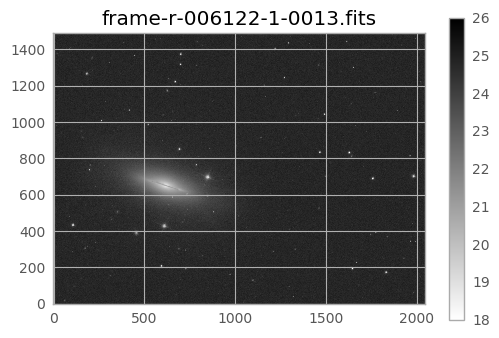

In [25]:
fig = plt.figure(dpi=100)
im = plt.imshow(mag_image, cmap='gray_r', clim=(26, 18), origin='lower')
foo = im.axes.set_title('frame-r-006122-1-0013.fits')
foo = im.axes.grid(True)
cb = plt.colorbar()

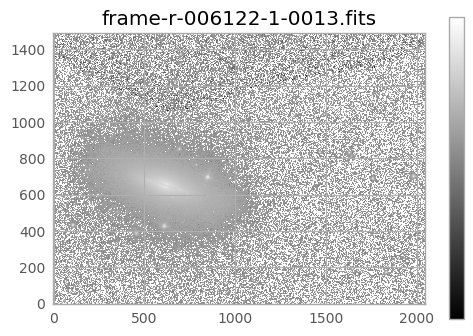

In [26]:
from matplotlib.colors import LogNorm
fig = plt.figure(dpi=100)
im = plt.imshow(image, cmap='gray', norm=LogNorm(), origin='lower')
foo = im.axes.set_title('frame-r-006122-1-0013.fits')
foo = im.axes.grid(True)
cb = plt.colorbar()

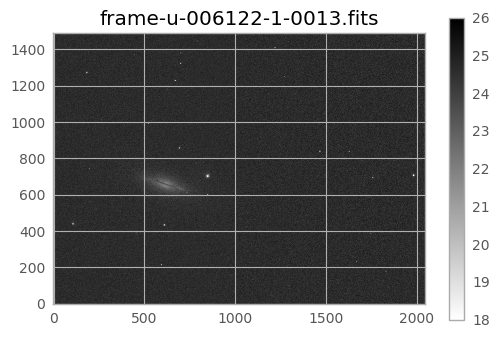

In [27]:
foo = display_frame(6122, 1, 13, 'u')

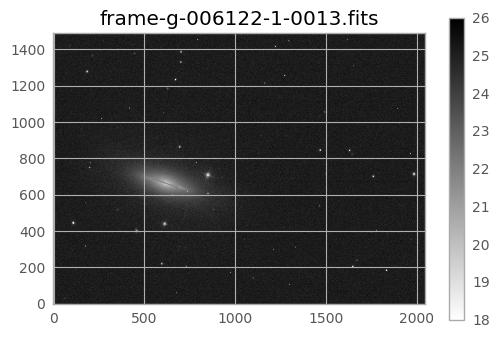

In [28]:
foo = display_frame(6122, 1, 13, 'g')

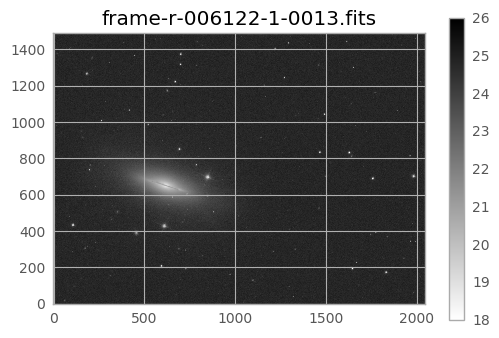

In [29]:
foo = display_frame(6122, 1, 13, 'r')

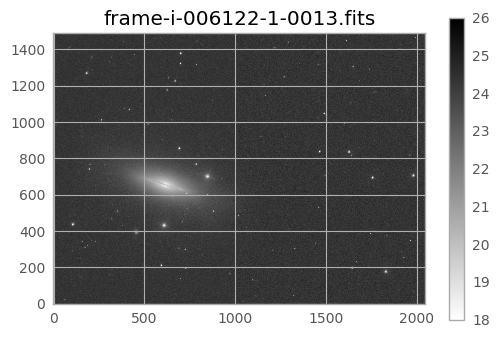

In [30]:
foo = display_frame(6122, 1, 13, 'i')

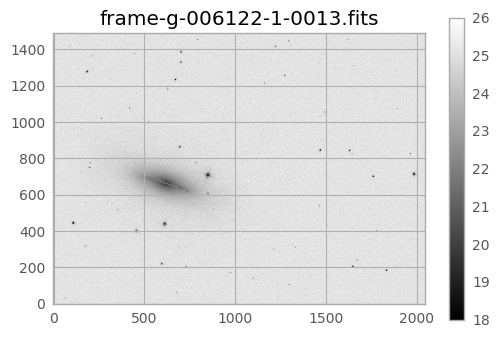

In [31]:
foo = display_frame(6122, 1, 13, 'g', invert=True)

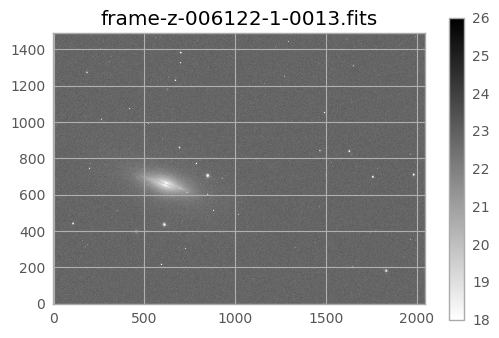

In [32]:
foo = display_frame(6122, 1, 13, 'z')

## Resources & References

* BOSS: [Kyle S. Dawson, *et al.*, "The Baryon Oscillation Spectroscopic Survey of SDSS-III," *Astron. J.* **145** (2013) 10.](http://adsabs.harvard.edu/abs/2013AJ....145...10D)
* eBOSS: [Kyle S. Dawson, *et al.*, "The SDSS-IV extended Baryon Oscillation Spectroscopic Survey: Overview and Early Data," *Astron. J.* **151** (2016) 44.](http://adsabs.harvard.edu/abs/2016AJ....151...44D)
* SDSS-IV: [Michael R. Blanton, *et al.*, "Sloan Digital Sky Survey IV: Mapping the Milky Way, Nearby Galaxies and the Distant Universe," *Astron. J.* **154** (2017) 28.](http://adsabs.harvard.edu/abs/2017AJ....154...28B)
* DR13: [Franco D. Albareti, *et al.*, "The 13th Data Release of the Sloan Digital Sky Survey: First Spectroscopic Data from the SDSS-IV Survey Mapping Nearby Galaxies at Apache Point Observatory," *Astrophys. J. Supp.* **233** (2017) 25.](http://adsabs.harvard.edu/abs/2017ApJS..233...25A)
* DR14: [Bela Abolfathi, *et al.*, "The Fourteenth Data Release of the Sloan Digital Sky Survey: First Spectroscopic Data from the extended Baryon Oscillation Spectroscopic Survey and from the Second Phase of the Apache Point Observatory Galactic Evolution Experiment," *Astrophys. J. Supp.* **235** (2018) 42.](http://adsabs.harvard.edu/abs/2018ApJS..235...42A)